In [1]:
import os
import re 
import csv
import nltk
import string
import fasttext
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split

Make sure you have downloaded your Kaggle token on your local machine (you can follow step 1 in this [tutorial](https://medium.com/@yvettewu.dw/tutorial-kaggle-api-google-colaboratory-1a054a382de0)). You will get a `kaggle.json` file that you can open with your favorite text editor. You will be able to see something like this:

`{“username”:”YOUR-USER-NAME”,”key”:”SOMETHING-VERY-LONG”}`. 

Next, you can copy and paste your username and key in the following cell so you can configure appropiate credentials to download the data in the next steps.

In [ ]:
os.environ["KAGGLE_USERNAME"] = "YOUR-USER-NAME"
os.environ["KAGGLE_KEY"] = "SOMETHING-VERY-LONG"

We will set a seed from now on so we can use it with all functions that use random number generators.

In [2]:
mySEED = 12345

# 1. Getting the data

In [ ]:
! kaggle datasets download stackoverflow/stacksample

Make directories and unzip downloaded files.

In [ ]:
%%bash
mkdir stacksample
unzip -j stacksample.zip Questions.csv -d stacksample/ 
unzip -j stacksample.zip Tags.csv -d stacksample/
rm stacksample.zip
mkdir data models predictions

# 2. Preparing the data

We begin by loading the data (both the Questions and Tags tables) by chunks. We have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0).

In [3]:
QuestionsFile = "stacksample/Questions.csv"
chunksize = 20000

df = None
for ratings in pd.read_csv(QuestionsFile, names=['id', 'title', 'body'], encoding = 'ISO-8859-1',  header=None , usecols=[0,5,6],error_bad_lines = False, chunksize=chunksize):
    if df is None:
        df = ratings.copy()
    else:
        df.append(ratings)
        
TagsFile = "stacksample/Tags.csv"
chunksize = 20000
df_tags = None
for ratings in pd.read_csv(TagsFile, names=['id', 'tag'], header=None , chunksize=chunksize):
    if df_tags is None:
        df_tags = ratings.copy()
    else:
        df_tags.append(ratings)

# 3. (Quick) Data exploration & visualization

Let's compute statistics over the frequency counts of the *tag* field in the tags dataframe.

In [4]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().describe()

,tag
count,3506.000000
mean,5.702510
std,27.213578
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,862.000000


Let's plot a histogram over the top-100 most frequent tags.

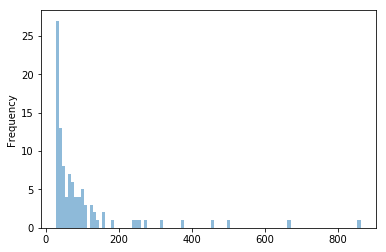

In [5]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).plot.hist(bins=100, alpha=0.5)

Create a dataframe with tags and frequency counts with the top-100 most frequent tags.

In [6]:
mytags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().head(100).reset_index()

Let's compute statistics as before, for the subset of the top-100 most frequent tags.

In [7]:
mytags.describe()

,tag
count,100.000000
mean,99.230000
std,128.606506
min,29.000000
25%,37.000000
50%,56.000000
75%,98.250000
max,862.000000


### Wordcloud of the top-100 most frequent tags

In [8]:
d = {}
for a, x in mytags.values:
    d[a] = x

In [9]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    random_state=mySEED,
    background_color = 'black').generate_from_frequencies(frequencies=d)

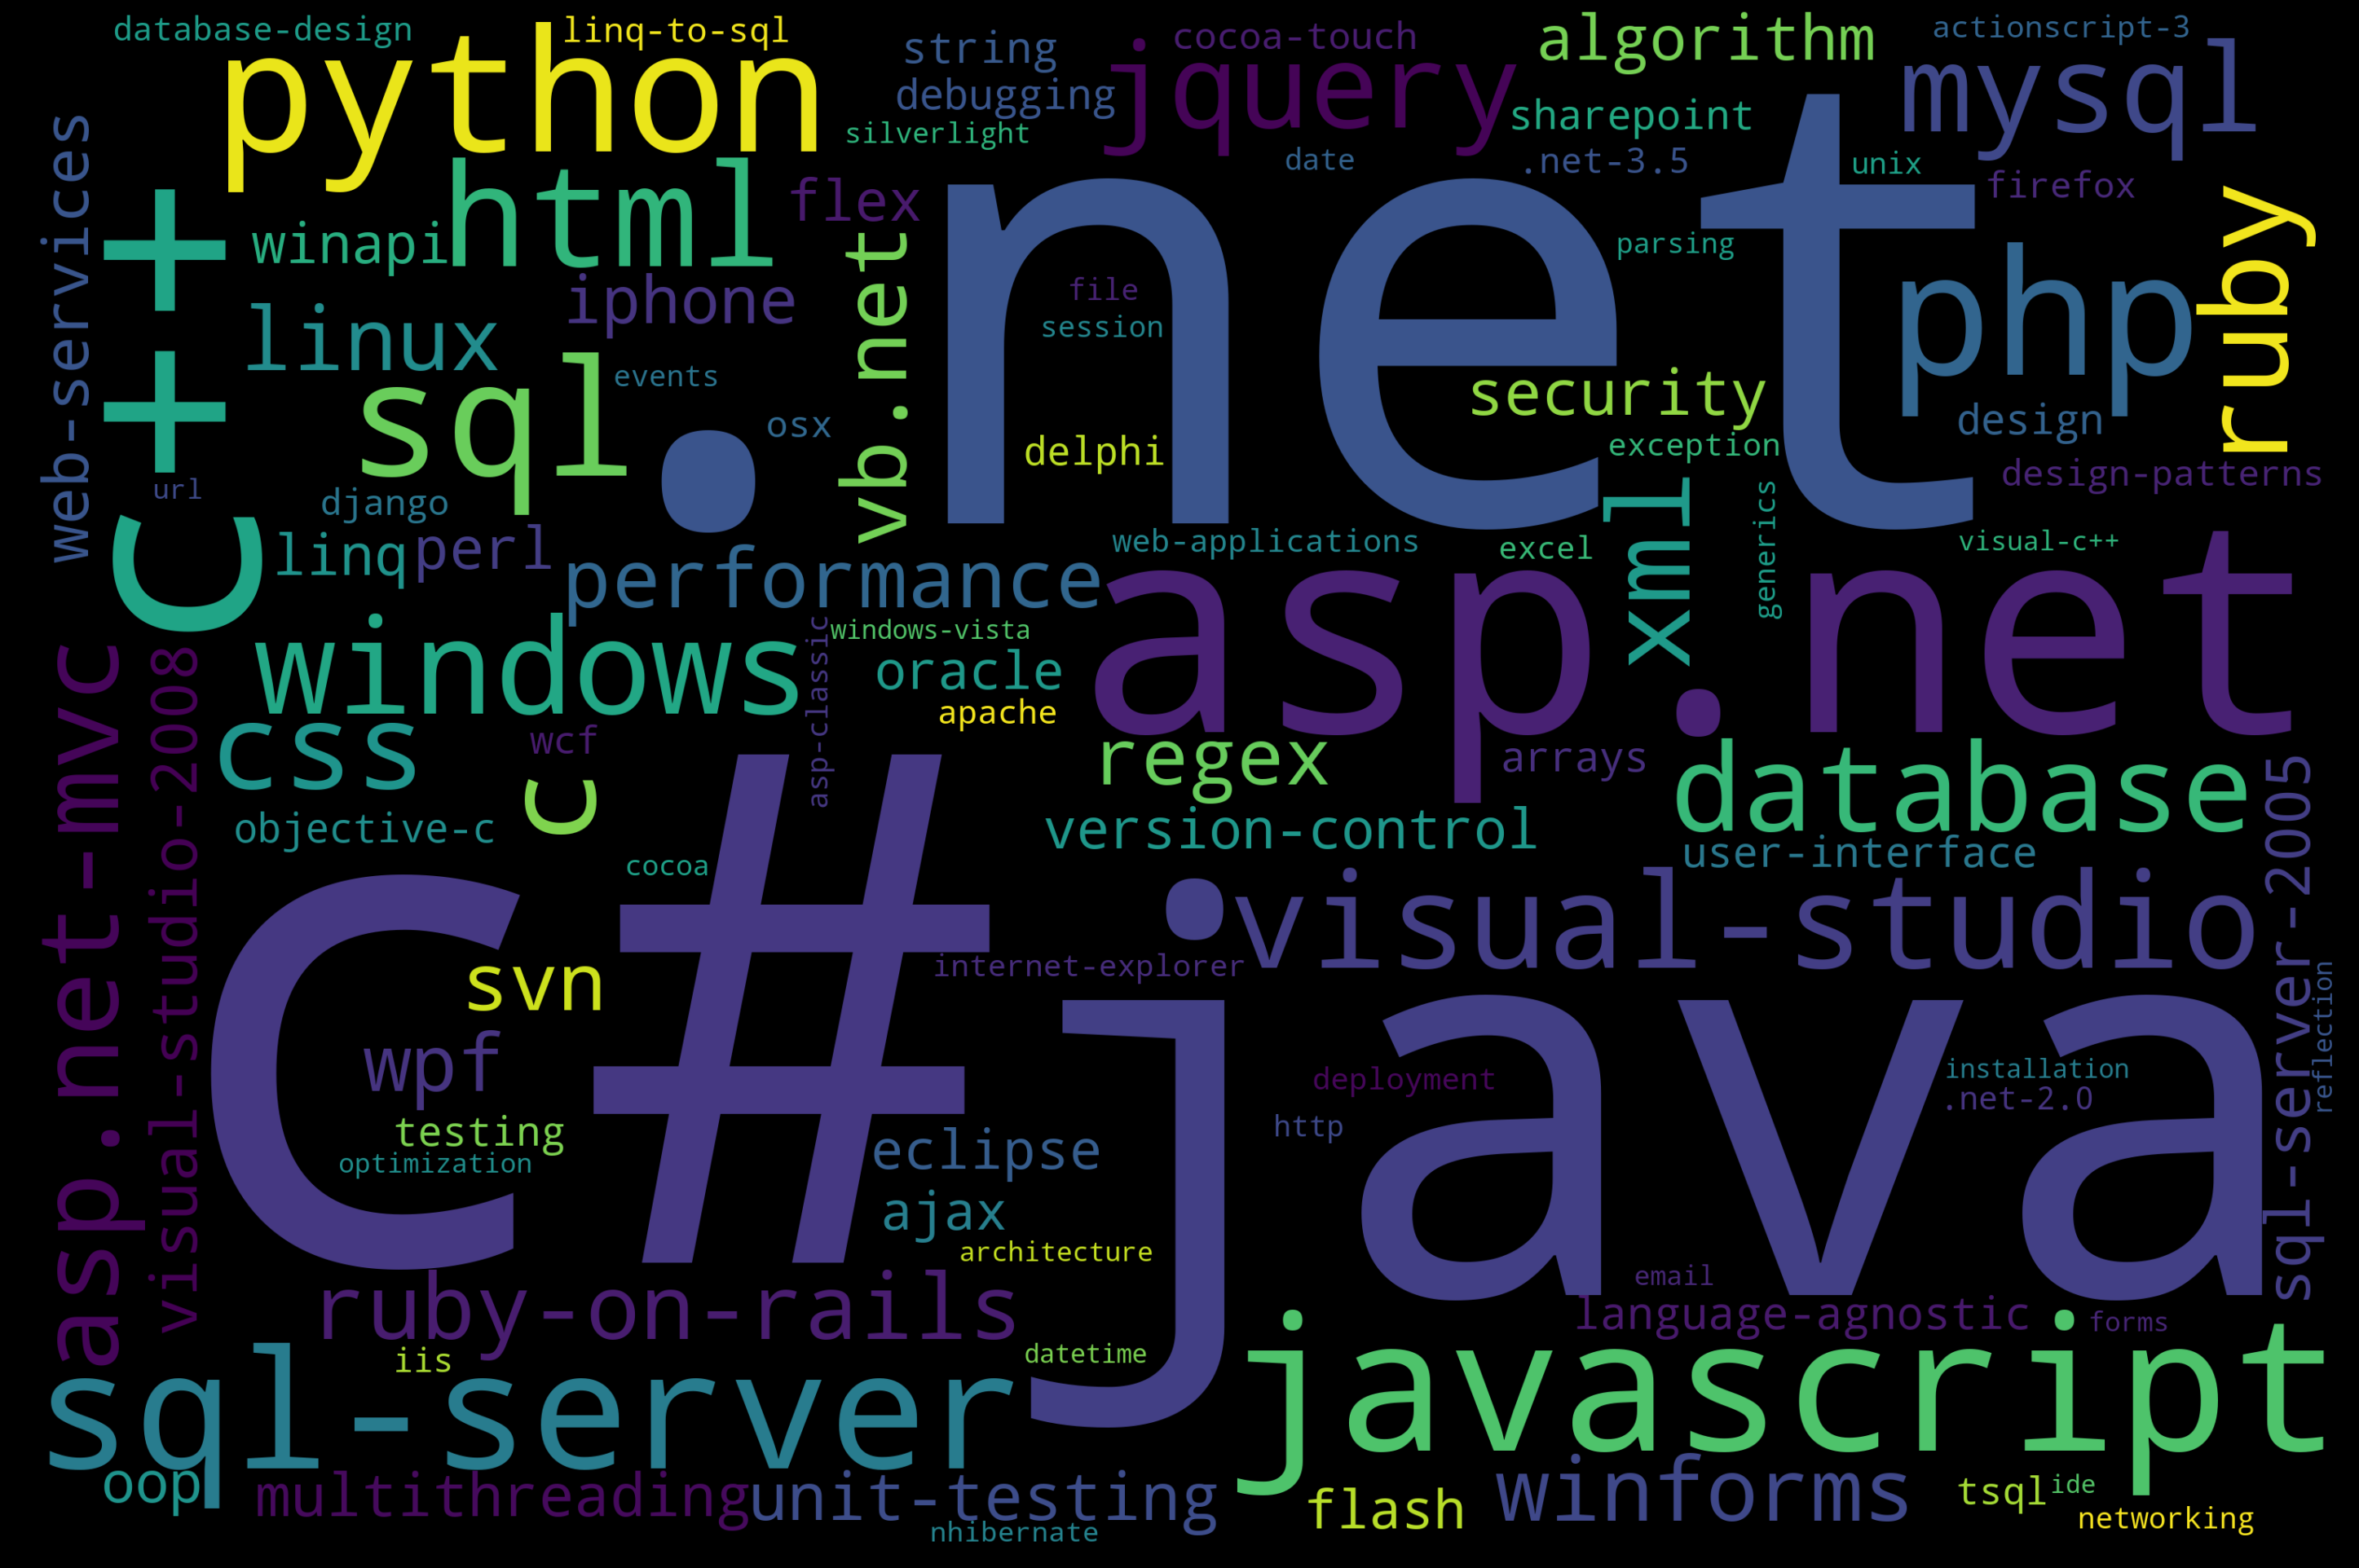

In [10]:
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
fig.savefig('toptags.png', dpi=fig.dpi)

Let's store the top-100 most frequent tags in a list.

In [11]:
topTags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).index.tolist()

Let's filter the tags dataframe based on the previous list.

In [12]:
df_tags = df_tags[df_tags.tag.isin(topTags)]

# 4. Processing the data

For both fastText and StarSpace (and Amazon's [BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html) too!), the input file has to be formatted in a way that each line contain a single sentence and the corresponding label(s) prefixed by __label__, e.g.  

``__label__database __label__oracle How to edit sessions parameters on Oracle 10g XE?``. 

Additionally, the input data has to be as clean as possible. The following function generates a preprocessed and clean data after removing HTML tags and unwanted punctuations. 

For both steps, we have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0). The following functions perform the aforementioned steps.

In [13]:
def clean_text(text):
    if not isinstance(text, str): 
        return text
    def cleanhtml(raw_html):
        cleanr = re.compile('<[^>]+>')
        cleantext = re.sub(cleanr, '', raw_html)
        return cleantext
    def replace_link(match):
        return '' if re.match('[a-z]+://', match.group(1)) else match.group(1)
    def removeContractions(raw_text):
        CONTRACTIONS = {"mayn't":"may not", "may've":"may have","isn't":"is not","wasn't":"was not","'ll":" will","'have": "have"}
        raw_text = raw_text.replace("’","'")
        words = raw_text.split()
        reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
        raw_text = " ".join(reformed)
        return raw_text
    text = cleanhtml(text)
    text = removeContractions(text)
    text = re.sub('<pre><code>.*?</code></pre>', '', text)
    text = re.sub('<a[^>]+>(.*)</a>', replace_link, text)
    #Remove hashtags
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text).split())
    #Remove punctuations
    text = ' '.join(re.sub("[\.\,\(\)\{\}\[\]\`\'\!\?\:\;\-\=]", " ", text).split())
    #text = text.translate(str.maketrans('','',string.punctuation))
    text = text.lower()
    return text

In [14]:
questions = df.values
tags = df_tags.values

all_rows=[]

for index, row in enumerate(questions):
    title = clean_text(row[1])
    tag_ids = [ tag[1] for tag_idx, tag in enumerate(tags) if tag[0]  == row[0] ]
    if(len(tag_ids)>0): 
        all_rows.append({"title":title, "tags":tag_ids})

In [15]:
nltk.download('punkt')

def preprocess(rows,output_file):
    pool = Pool(processes=cpu_count())
    transformed_rows = pool.map(transform_instance, rows)
    pool.close() 
    pool.join()
    with open(output_file, "w") as txt_file:
        for line in transformed_rows:
            txt_file.write(" ".join(line) + "\n")
            
def transform_instance(row):
    cur_row = []
    label = ["__label__" + str(tag) for tag in row["tags"] if tag]
    label = " ".join(map(str, label))
    cur_row.append(str(label))
    cur_row.extend(nltk.word_tokenize(row["title"]))
    return cur_row

[nltk_data] Downloading package punkt to /Users/pjcv89/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 5. Creating training, validation and test sets

## For fastText and StarSpace models

Apply the previous defined functions and split the data pseudorandomly on train, validation and test sets, and store them in local directory.

In [16]:
train, valid = train_test_split(all_rows,test_size=0.20,random_state=mySEED)
valid, test = train_test_split(valid,test_size=0.50,random_state=mySEED)

preprocess(train, 'data/train')    
preprocess(valid, 'data/valid')
preprocess(test, 'data/test')

In [17]:
pdf_test = pd.DataFrame(test).explode('tags')

We can see how our test data looks like after exploding the *tags* column.

In [18]:
pdf_test.head(10)

,title,tags
0,what are the benefits to marking a field as re...,c#
1,is it ok to return a keyvaluepair from a net f...,.net
2,how do i split a string on a fixed character s...,java
2,how do i split a string on a fixed character s...,string
3,how to set wpf s grid rowdefinitions via style,wpf
4,find java classes implementing an interface,java
5,accessing stored structures for which i have a...,c++
5,accessing stored structures for which i have a...,xml
6,difference between user control and custom con...,asp.net
7,implementing a search page using url parameter...,asp.net


# 6. Building the models

Before training and using the models for predictions, let's take our test set and make a list with the true tags for each instance in the set. We are going to collect predictions for each model and append a new column to this dataframe with the corresponding predictions each time. In order to simplify the analysis, suppose we want to retrieve the top-3 predictions for each model. At the end, we will compute metrics per instance ([precision@k and recall@k](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Precision_at_K)) with $k=3$ predictions per model and we will be able to compute statistics to compare models. Also, from now on, we will be considering an embedding dimension of 100 in all models, for comparison purposes.

In [19]:
indexes = pdf_test.title.unique()
grouped = pdf_test.groupby('title').apply(lambda x: list(x.tags)).to_frame().reindex(indexes) \
                .reset_index().rename(columns={0: "true"})
grouped['n_tags'] = grouped['true'].apply(lambda x: len(x))

Let's take a small sample. This will be our working sample to show predictions for each model from now on.

In [20]:
grouped[grouped['n_tags']>2].sample(15,random_state=mySEED).drop(columns='n_tags')

,title,true
297,how can i add sessions to my perl web app,"[perl, web-applications, session]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]"
165,asp net iis service unavailable,"[asp.net, .net, iis]"
528,dragging an image in wpf,"[.net, wpf, user-interface]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]"


## 6.1 fastText: baseline

We can use the fastText's Python API to build a quick baseline. Let's hardcode some parameters. Please refer to the official [tutorial](https://github.com/facebookresearch/fastText/blob/master/docs/supervised-tutorial.md) for more information and examples. Also please refer to the full [list of options](https://fasttext.cc/docs/en/options.html) to see all available arguments. Be aware that fastText's vectors and models have a nondeterministic behaviour since it uses a variant of asynchronous SGD (see this [issue](https://github.com/facebookresearch/fastText/issues/116)).

In [21]:
ft_baseline = fasttext.train_supervised(input="data/train", lr=0.1, epoch=10, wordNgrams=1, dim=100)

Note that we can compute average *precision@k* and *recall@k* over the test set using fastText built-in tool for metrics. We can ask for precision@k and recall@k for $k=1,\dots,4$ in the following way.

In [22]:
[ft_baseline.test("data/test",k=i) for i in range(1,5)]

[(592, 0.3902027027027027, 0.22826086956521738),
 (592, 0.26013513513513514, 0.30434782608695654),
 (592, 0.19594594594594594, 0.3438735177865613),
 (592, 0.15920608108108109, 0.3725296442687747)]

Let's make it with a neater format.

In [23]:
metrics = pd.DataFrame([ft_baseline.test("data/test",k=i) for i in range(1,5)]) \
            .rename(columns={'index':'at',0:'n',1:'precision',2:'recall'}) \
            .drop(columns=['n'])
metrics.index=metrics.index+1
metrics = metrics.rename('at_{}'.format)
display(metrics)

,precision,recall
at_1,0.390203,0.228261
at_2,0.260135,0.304348
at_3,0.195946,0.343874
at_4,0.159206,0.372530


If we want to persist this model we can do it by using its *save_model* method.

In [24]:
ft_baseline.save_model("models/ft_baseline.bin")
del ft_baseline

We can see what is the size in megabytes of this model.

In [25]:
! ls -lh models | grep ft_baseline

-rw-r--r--  1 pjcv89  staff   2,3M  7 mar 18:19 ft_baseline.bin


And we can load it using fastText's *load_model* function.

In [26]:
ft_baseline = fasttext.load_model("models/ft_baseline.bin")

Let's define a function to perform predictions and get the top-3 most probable tags for each instance of the test set.

In [27]:
def get_FTpredictions(model,sentence,threshold=None,k=3):
    '''
    Function to get a list with predictions for a sentence, given a fastText model
    and given one of: a probability threshold, or a desired number k of top-k predictions.
    '''
    if threshold:
        labels, probs = model.predict(sentence.lower(),k=k)
        candidates = [labels[index]  for index in range(0,k) if probs[index] >= threshold]
    else:
        candidates = model.predict(sentence.lower(),k=k)[0]
    output = [candidate.replace("__label__","") for candidate in candidates]
    return output

Apply the previous function over the *title* field in the test set to get the predictions.

In [28]:
grouped['ft_baseline'] = grouped.title.apply(lambda sentence: get_FTpredictions(ft_baseline,sentence))

Let's take a look to predictions on our small sample.

In [29]:
grouped[grouped['n_tags']>2].sample(15,random_state=mySEED).drop(columns='n_tags')

,title,true,ft_baseline
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, java, python]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, javascript, c#]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]"


##  6.2 fastText: tuned model

Please note that the current version of fastText's Python API stored in PyPI (0.9.1 version, as of March 2020) doesn't support the hyperparameter autotuning tool yet. However, CLI does and also the Python API installed from the source code, as we have done in the installation script. We will show how to perform the tuning using both CLI and the Python API. 

Please note that we can fix a specific hyperaparameter (in this example, the embedding dimension `dim`), and also we can constrain the model size via `autotune-modelsize` parameter, since it is also a hyperparameter! We also need to provide a time constraint in seconds via the `autotune-duration` parameter.

We will set 3 minutes of tuning (180 seconds) and a maximum model size of 5 megabytes. Later we can try to increase increase the time constraint and/or change the maximum model size and see how performance changes. Note: If the proceess is automatically killed maybe you are running out of memory and you may need to decrease the `autotune-duration` parameter and/or the `autotune-modelsize` parameter. If you are running this notebook in a Docker container, you may consider increasing the default memory of the virtual machines as explained [here](https://stackoverflow.com/questions/44533319/how-to-assign-more-memory-to-docker-container).

In our experience, tuning for $\sim$ 5 mins should be enough to reach an average recall@3 $\gt 0.40$ and tuning for $\sim$ 15 mins can lead to an average recall@3 $\gt 0.60$, on the test set.

Please refer to the [documentation](https://fasttext.cc/docs/en/autotune.html) for more information and more and examples. Also if you want to know more about what is going on under the hood, please refer to this [entry](https://ai.facebook.com/blog/fasttext-blog-post-open-source-in-brief/) in FAIR's site.

If we would like to train the tuned model using the Python API, we would do the following. However, this doesn't print any progress information.

```python
ft_tuned = fasttext.train_supervised(input='data/train',
           autotuneValidationFile='data/valid',
            dim=100,autotuneDuration=180,
            autotuneModelSize="5M")
```

If we would like to train the tuned model using the fastText CLI instead, we would do the following.

In [30]:
! fastText/build/fasttext supervised \
-input data/train \
-autotune-validation data/valid \
-output models/ft_tuned \
-dim 100 \
-autotune-duration 180 \
-autotune-modelsize 5M

Progress: 100.0% Trials:    7 Best score:  0.283554 ETA:   0h 0m 0s4m27s 4m 9s4m 5s 9s  0h 3m 1s 1m55s   3 Best score:  0.283554 ETA:   0h 1m46sm39s32s24sm 9sh 0m44s Best score:  0.283554 ETA:   0h 0m10s
Training again with best arguments
Read 0M words
Number of words:  5631
Number of labels: 100
Progress: 100.0% words/sec/thread:  137605 lr:  0.000000 avg.loss:  3.716834 ETA:   0h 0m 0s


We can see the model size as before. Please note that the suffix of the constraint-size (i.e. compressed) model now is *.ftz* instead of *.bin*

In [31]:
! ls -lh models | grep ft_tuned

-rw-r--r--  1 pjcv89  staff   520K  7 mar 18:24 ft_tuned.ftz
-rw-r--r--  1 pjcv89  staff   5,3M  7 mar 18:24 ft_tuned.vec


The tuned model is persisted in the specified location. We can load it as before so we can use it interactively here.

In [32]:
ft_tuned = fasttext.load_model("models/ft_tuned.ftz")

Let's see the metrics as before.

In [33]:
metrics = pd.DataFrame([ft_tuned.test("data/test",k=i) for i in range(1,5)]) \
            .rename(columns={'index':'at',0:'n',1:'precision',2:'recall'}) \
            .drop(columns=['n'])
metrics.index=metrics.index+1
metrics = metrics.rename('at_{}'.format)
display(metrics)

,precision,recall
at_1,0.466216,0.272727
at_2,0.317568,0.371542
at_3,0.247185,0.433794
at_4,0.206503,0.483202


Get predictions.

In [34]:
grouped['ft_tuned'] = grouped.title.apply(lambda sentence: get_FTpredictions(ft_tuned,sentence))

Take a look to predictions.

In [35]:
grouped[grouped['n_tags']>2].sample(20,random_state=mySEED).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]","[java, xml, eclipse]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[c#, c, php]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]","[python, java, perl]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]","[sql-server, sql, sql-server-2005]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, java, python]","[python, c++, ruby]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[asp.net, sql-server, .net]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net-mvc, asp.net, vb.net]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, javascript, c#]","[.net, c#, asp.net]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]","[java, python, .net]"


##  Detour: How do fastText's subwords help?

Let's see how subword-level information is exploited in fastText to handle noisy variations of input text (e.g. misspellings and/or unseen words).

Without misspellings:

In [36]:
ft_tuned.predict("help with unit testing in a python app using django",k=3)

(('__label__python', '__label__perl', '__label__django'),
 array([0.88599646, 0.01380424, 0.007898  ]))

With some misspellings:

In [37]:
ft_tuned.predict("help with unitt testingg in a pythun app using django",k=3)

(('__label__python', '__label__c', '__label__perl'),
 array([0.33613312, 0.04827444, 0.03080726]))

## Scalable batch inference

Suppose we want to perform offline batch inference over a possibly big text file, reading an input file and writing a new file with the top-1 predictions. We can do it in a scalable way without loading data in memory in the following way, via Python generators.

In [38]:
def keep_sentence_field(line):
    '''
    Function to keep only the text input given a labeled instance with fastText format.
    Example
    Input:
    '__label__python __label__django help with unit testing in a python app using django'
    Output:
    'help with unit testing in a python app using django'
    '''
    return ' '.join(line.split()[1:]) 

def predict_sentence(model,sentence):
    '''
    Function to provide a clean top-1 prediction from a sentence using a fastText model.
    Example
    Input:
    'help with unit testing in a python app using django'
    Output:
    'python'
    '''
    return model.predict(sentence,k=1)[0][0].replace('__label__','')

# Location of input file
inputFile = 'data/test'

# Define Python generators to 1) read lines, 2) keep only the sentence field, 3) get clean top-1 prediction
lines = (line for line in open(inputFile,encoding="ISO-8859-1"))
sentences = (keep_sentence_field(line) for line in lines)
predictions = (predict_sentence(ft_tuned,sentence) for sentence in sentences)

# Location of output file
outputFile = 'predictions/ft_tuned_cleanpreds'

# Apply the generators and write predictions
with open(outputFile, 'w') as file:
    for prediction in predictions:
        file.write(prediction+'\n')
    file.close()

In [39]:
top_one = pd.read_csv('predictions/ft_tuned_cleanpreds',sep='   ',header = None, names=['most_likely'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


If we would want to join these top-1 predictions with our test data already available in a pandas dataframe, we would merge data by both indexes as follows, and double check that top-1 predictions match with the first entry in the predictions obtained before.

In [40]:
grouped.merge(top_one,left_index=True,right_index=True)[['true','ft_tuned','most_likely']].head(10)

,true,ft_tuned,most_likely
0,[c#],"[c#, .net, javascript]",c#
1,[.net],"[.net, c#, asp.net]",.net
2,"[java, string]","[c#, python, .net]",c#
3,[wpf],"[.net, c#, python]",.net
4,[java],"[java, php, regex]",java
5,"[c++, xml]","[c#, .net, php]",c#
6,[asp.net],"[asp.net, javascript, jquery]",asp.net
7,"[asp.net, asp.net-mvc]","[asp.net, asp.net-mvc, vb.net]",asp.net
8,[ruby],"[ruby, ruby-on-rails, flex]",ruby
9,"[c#, sql]","[sql, sql-server, sql-server-2005]",sql


## 6.3 StarSpace: no label weights

StarSpace's syntax is very similar to fastText's. Please refer to StarSpace's repo. [README](https://github.com/facebookresearch/StarSpace/blob/master/README.md) for more information. Since our problem is one of text classification, we use *trainMode = 0*. To see the full list of available arguments you can just type `Starspace/starspace` in the command line.

In [41]:
! Starspace/starspace 

Usage: need to specify whether it is train or test.

"starspace train ..."  or "starspace test ..."

The following arguments are mandatory for train: 
  -trainFile       training file path
  -model           output model file path

The following arguments are mandatory for test: 
  -testFile        test file path
  -model           model file path

The following arguments for the dictionary are optional:
  -minCount        minimal number of word occurences [1]
  -minCountLabel   minimal number of label occurences [1]
  -ngrams          max length of word ngram [1]
  -bucket          number of buckets [2000000]
  -label           labels prefix [__label__]

The following arguments for training are optional:
  -initModel       if not empty, it loads a previously trained model in -initModel and carry on training.
  -trainMode       takes value in [0, 1, 2, 3, 4, 5], see Training Mode Section. [0]
  -fileFormat      currently support 'fastText' and 'labelDoc', see File Format Section. [fast

Train a model the standard way, without label weights (with argument `useWeight 0`).

In [42]:
! Starspace/starspace train \
-trainMode 0 \
-trainFile data/train \
-validationFile data/valid \
-useWeight 0 \
-model models/ss_unweighted \
-loss softmax \
-lr 0.1 \
-epoch 10 \
-batchSize 1 \
-ngrams 1 \
-adagrad 0

Arguments: 
lr: 0.1
dim: 100
epoch: 10
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: softmax
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 1
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 0
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to initialize starspace model.
Build dict from input file : data/train
Read 0M words
Number of words in dictionary:  5630
Number of labels in dictionary: 100
Loading data from file : data/train
Total number of examples loaded : 4730
Loading data from file : data/valid
Total number of examples loaded : 591
Training epoch 0: 0.1 0.01
Epoch: 99.8%  lr: 0.090000  loss: 3.693646  eta: <1min   tot: 0h0m0s  (10.0%)s  (5.7%)
 ---+++                Epoch    0 Train error : 3.67346644 +++--- ☃
Epoch: 98.5%  lr: 0.000000  loss: 3.500030  eta: <1min   tot: 0h0m0s  (9.8%)
Validation err

Test the previous model and persist raw predictions.

In [43]:
! Starspace/starspace test \
-model models/ss_unweighted.tsv \
-testFile data/test \
-predictionFile predictions/rawpreds \
-K 3

Arguments: 
lr: 0.01
dim: 100
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to load a trained embedding model in tsv format.
Loading dict from model file : models/ss_unweighted.tsv
Number of words in dictionary:  5630
Number of labels in dictionary: 100
Loading model from file models/ss_unweighted.tsv
Model loaded.
Loading data from file : data/test
Total number of examples loaded : 592
Predictions use 100 known labels.
Evaluation Metrics : 
hit@1: 0.165541 hit@10: 0.574324 hit@20: 0.704392 hit@50: 0.890203 mean ranks : 18.1149 Total examples : 592


StarSpace doesn't provide predictions in a neat format as fastText's, though we can still get clean predictions after some processing. The raw predictions look like this:

In [44]:
! head -20 predictions/rawpreds 

Example 0:
LHS:
what are the benefits to a field as readonly in c # 
RHS: 
__label__c# 
Predictions: 
(++) [0.548657]	__label__c# 
(--) [0.480395]	__label__excel 
(--) [0.459783]	__label__reflection 

Example 1:
LHS:
is it to return a from a net function 
RHS: 
__label__.net 
Predictions: 
(++) [0.557509]	__label__.net 
(--) [0.556531]	__label__c# 
(--) [0.55526]	__label__winapi 



If we want to store the top predictions for each instance in the test set, we will need to parse the raw predictions file via **grep** and **awk**. For example, if we want to have the input text and their top predictions for each instance, we can do the following:

In [45]:
%%bash
cd predictions   
grep -A3 Predictions: rawpreds | awk -F'__label__' '{print $2}' | awk -v RS= '{gsub(/\n/, " ")}3'  > preds 
awk '/LHS:/ {for(i=1; i<=1; i++) {getline; print}}' rawpreds > lhss 
paste -d ',' lhss preds > cleanpreds && rm lhss preds

This way we can have our predictions in the following format:

In [46]:
! head -10 predictions/cleanpreds

what are the benefits to a field as readonly in c # ,c#  excel  reflection 
is it to return a from a net function ,.net  c#  winapi 
how do i split a string on a fixed character sequence ,string  perl  datetime 
how to set wpf s grid via style ,wpf  delphi  winapi 
find java classes implementing an interface ,java  reflection  generics 
accessing stored structures for which i have an xml description ,xml  arrays  generics 
difference between user control and custom control ,asp.net  winforms  asp.net-mvc 
implementing a search page using url parameters in asp net and asp net mvc ,asp.net  vb.net  asp.net-mvc 
in ruby why does my interactive debugging session always say `` no available '' ,visual-c++  c++  c 
sql missing a row in loop ,tsql  datetime  arrays 


Now we can read our clean predictions and perform some processing to have the predictions in the same format in our pandas dataframe.

In [47]:
ss_predictions = pd.read_csv('predictions/cleanpreds',sep=',',names=['title','ss_unweighted'])
ss_predictions['title'] = ss_predictions['title'].str.strip()
ss_predictions['ss_unweighted'] = ss_predictions['ss_unweighted'].str.strip().apply(lambda x: x.split('  '))

Now we can see StarSpace's model predictions in a tidy way.

In [48]:
ss_predictions.head(10)

,title,ss_unweighted
0,what are the benefits to a field as readonly i...,"[c#, excel, reflection]"
1,is it to return a from a net function,"[.net, c#, winapi]"
2,how do i split a string on a fixed character s...,"[string, perl, datetime]"
3,how to set wpf s grid via style,"[wpf, delphi, winapi]"
4,find java classes implementing an interface,"[java, reflection, generics]"
5,accessing stored structures for which i have a...,"[xml, arrays, generics]"
6,difference between user control and custom con...,"[asp.net, winforms, asp.net-mvc]"
7,implementing a search page using url parameter...,"[asp.net, vb.net, asp.net-mvc]"
8,in ruby why does my interactive debugging sess...,"[visual-c++, c++, c]"
9,sql missing a row in loop,"[tsql, datetime, arrays]"


Merge these predictions with the dataframe with other predictions.

In [49]:
grouped = grouped.merge(ss_predictions.drop(columns=['title']),left_index=True,right_index=True)

Take a look to predictions.

In [50]:
grouped[grouped['n_tags']>2].sample(20,random_state=mySEED).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned,ss_unweighted
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]","[java, xml, eclipse]","[regex, arrays, datetime]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[c#, c, php]","[c#, generics, .net]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]","[python, java, perl]","[perl, python, parsing]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]","[sql-server, sql, sql-server-2005]","[string, c, c++]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, java, python]","[python, c++, ruby]","[eclipse, file, ide]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[asp.net, sql-server, .net]","[java, perl, regex]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net-mvc, asp.net, vb.net]","[asp.net, wcf, iis]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, javascript, c#]","[.net, c#, asp.net]","[linq-to-sql, oracle, linq]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]","[java, python, .net]","[unit-testing, testing, ide]"


## 6.4 StarSpace: label weights

StarSpace supports training with both input (words) weights and label weights. Suppose we want to train a model with only label weights to see if we can improve performance. To give the appropiate format to the training set, we can proceed as follows. Please note that the following is just for exposicion purposes. In a real world application, we would want to use command line tools.

Read already available training data.

In [51]:
df_labels = pd.read_csv('data/train',names=['single'])

In [52]:
df_labels.head(10)

,single
0,__label__user-interface which factor gui tutor...
1,__label__python how are post and get variables...
2,__label__sql __label__sql-server semi tricky s...
3,__label__regex regex in vb6
4,__label__database-design should i have a dedic...
5,__label__delphi how to track down tricky memor...
6,__label__html can you nest html forms
7,__label__language-agnostic what is an ideal va...
8,__label__wpf reset expander to default collaps...
9,__label__sql-server __label__excel how should ...


Separate each line into two columns, one with labels and the another one with the input text.

In [53]:
df_labels['text'] = df_labels['single'].apply(lambda x: x.split(" ")) \
.apply(lambda line: list(filter(lambda x: "__label__" not in x, line))) \
.apply(lambda line: ' '.join(line))

df_labels['single'] = df_labels['single'].apply(lambda x: x.split(" ")) \
.apply(lambda line: list(filter(lambda x: "__label__" in x, line))).to_frame()

In [54]:
df_labels.head(10)

,single,text
0,[__label__user-interface],which factor gui tutorial/example app
1,[__label__python],how are post and get variables handled in python
2,"[__label__sql, __label__sql-server]",semi tricky sql query
3,[__label__regex],regex in vb6
4,[__label__database-design],should i have a dedicated primary key field
5,[__label__delphi],how to track down tricky memory leak with fastmm
6,[__label__html],can you nest html forms
7,[__label__language-agnostic],what is an ideal variable naming convention fo...
8,[__label__wpf],reset expander to default collapse behavior
9,"[__label__sql-server, __label__excel]",how should i import highly formatted data from...


Create column with labels count and split lists of labels into one column per label.

In [55]:
df_labels['n_labels'] = df_labels['single'].apply(lambda x: len(x))
df_labels = df_labels['single'].apply(pd.Series).add_prefix('label_') \
            .merge(df_labels.drop(columns=['single']),left_index=True,right_index=True)

Which is the maximum number of tags among instances in the training set?

In [56]:
df_labels.n_labels.max()

5

After realizing we have at most 5 labels per instance, we split each label into different columns.

In [57]:
df_labels.replace(np.nan, '', regex=True).sample(10,random_state=mySEED)

,label_0,label_1,label_2,label_3,label_4,text,n_labels
623,__label__javascript,,,,,modifying the window opened by javascript s ``...,1
26,__label__c#,__label__visual-studio,,,,hiding a function,2
1550,__label__c#,__label__.net,,,,what are the best/most popular ways to do aspe...,2
1513,__label__asp.net,__label__linq,,,,dropdownlist with linqdatasource and an empty ...,2
2861,__label__c#,__label__.net,__label__web-services,,,how to programatically read the documentation ...,3
2416,__label__html,__label__css,,,,css layers ordering and arranging,2
4103,__label__asp.net,,,,,enter key to insert newline in asp net multili...,1
278,__label__.net,__label__wpf,__label__events,,,how to retrieve sender in click handler from t...,3
4241,__label__c#,,,,,what is returned when i call tostring on an un...,1
727,__label__asp.net,__label__unit-testing,,,,is there any way to use xmlsitemapprovider wit...,2


We need to define which weights are going to give. Assuming zero-based index and weights $w_i$ corresponding to labels $label_i$ for $i=0,\dots,4$ as in the table above, suppose we decide to
assign the following weights:

1. If we have one label, $w_0 = 1.0$.
2. If we have two labels, $w_0 = 0.75$ and $w_1 = 0.25$.
3. If we have three labels, $w_0 = 0.50$, $w_1 = 0.30$ and $w_2 = 0.20$.
4. If we have four labels, $w_0 = 0.40$, $w_1 = 0.25$, $w_2 = 0.20$ and $w_3 = 0.15$.
5. If we have five labels, $w_0 = 0.30$, $w_1 = 0.25$, $w_2 = 0.20$, $w_3 = 0.15$ and $w_4 = 0.10$.

Let's make a function according to the rules defined above and apply it row-wise.

In [58]:
def make_weights(n_labels):
    if n_labels == 1:
        weights = [1.0,0,0,0,0]
    elif n_labels == 2:
        weights = [0.75,0.25,0,0,0]
    elif n_labels == 3:
        weights = [0.50,0.30,0.20,0]
    elif n_labels == 4:
        weights = [0.40,0.25,0.20,0.15,0]
    elif n_labels == 5:
        weights = [0.30,0.25,0.20,0.15,0.10]
    return [":"+str(i) for i in weights]

Apply the previous defined function and match each weight $w_i$ with label $label_i$ for each $i$.

In [59]:
df_labels = df_labels['n_labels'].apply(lambda n: make_weights(n)).apply(pd.Series).add_prefix('weight_') \
                .merge(df_labels.drop(columns='n_labels'),left_index=True,right_index=True)

Overwrite label columns, now with with weights.

In [60]:
df_labels['label_0'] = df_labels['label_0']+df_labels['weight_0']
df_labels['label_1'] = df_labels['label_1']+df_labels['weight_1']
df_labels['label_2'] = df_labels['label_2']+df_labels['weight_2']
df_labels['label_3'] = df_labels['label_3']+df_labels['weight_3']
df_labels['label_4'] = df_labels['label_4']+df_labels['weight_4']

Drop weights columns.

In [61]:
df_labels = df_labels[df_labels.columns.drop(list(df_labels.filter(regex='weight')))]

In [62]:
df_labels.replace(np.nan, '', regex=True).sample(10,random_state=mySEED)

,label_0,label_1,label_2,label_3,label_4,text
623,__label__javascript:1.0,,,,,modifying the window opened by javascript s ``...
26,__label__c#:0.75,__label__visual-studio:0.25,,,,hiding a function
1550,__label__c#:0.75,__label__.net:0.25,,,,what are the best/most popular ways to do aspe...
1513,__label__asp.net:0.75,__label__linq:0.25,,,,dropdownlist with linqdatasource and an empty ...
2861,__label__c#:0.5,__label__.net:0.3,__label__web-services:0.2,,,how to programatically read the documentation ...
2416,__label__html:0.75,__label__css:0.25,,,,css layers ordering and arranging
4103,__label__asp.net:1.0,,,,,enter key to insert newline in asp net multili...
278,__label__.net:0.5,__label__wpf:0.3,__label__events:0.2,,,how to retrieve sender in click handler from t...
4241,__label__c#:1.0,,,,,what is returned when i call tostring on an un...
727,__label__asp.net:0.75,__label__unit-testing:0.25,,,,is there any way to use xmlsitemapprovider wit...


Collapse labels and text into one single columnn as at the beginning.

In [63]:
df_labels = df_labels[df_labels.columns].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1).to_frame()

In [64]:
df_labels.head(10)

,0
0,__label__user-interface:1.0 which factor gui t...
1,__label__python:1.0 how are post and get varia...
2,__label__sql:0.75 __label__sql-server:0.25 sem...
3,__label__regex:1.0 regex in vb6
4,__label__database-design:1.0 should i have a d...
5,__label__delphi:1.0 how to track down tricky m...
6,__label__html:1.0 can you nest html forms
7,__label__language-agnostic:1.0 what is an idea...
8,__label__wpf:1.0 reset expander to default col...
9,__label__sql-server:0.75 __label__excel:0.25 h...


Save into a text file so StarSpace can read it.

In [65]:
df_labels.to_csv('data/train_weighted',index=False,sep=' ',header=False,encoding='utf-8',escapechar=' ',quoting=csv.QUOTE_NONE)

Let's take a look to the text file to double check.

In [66]:
! head -10 data/train_weighted

__label__user-interface:1.0  which  factor  gui  tutorial/example  app
__label__python:1.0  how  are  post  and  get  variables  handled  in  python
__label__sql:0.75  __label__sql-server:0.25  semi  tricky  sql  query
__label__regex:1.0  regex  in  vb6
__label__database-design:1.0  should  i  have  a  dedicated  primary  key  field
__label__delphi:1.0  how  to  track  down  tricky  memory  leak  with  fastmm
__label__html:1.0  can  you  nest  html  forms
__label__language-agnostic:1.0  what  is  an  ideal  variable  naming  convention  for  loop  variables
__label__wpf:1.0  reset  expander  to  default  collapse  behavior
__label__sql-server:0.75  __label__excel:0.25  how  should  i  import  highly  formatted  data  from  excel  to  a  database


Train a model with this new train data with label weights (with argument `useWeight 1`).

In [67]:
! Starspace/starspace train \
-trainFile data/train_weighted \
-validationFile data/valid \
-useWeight 1 \
-model models/ss_weighted \
-loss softmax \
-lr 0.1 \
-epoch 10 \
-batchSize 1 \
-ngrams 1 \
-adagrad 0

Arguments: 
lr: 0.1
dim: 100
epoch: 10
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: softmax
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 1
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 0
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 1
weightSep: :
Start to initialize starspace model.
Build dict from input file : data/train_weighted
Read 0M words
Number of words in dictionary:  5631
Number of labels in dictionary: 100
Loading data from file : data/train_weighted
Total number of examples loaded : 4730
Loading data from file : data/valid
Total number of examples loaded : 591
Training epoch 0: 0.1 0.01
Epoch: 99.8%  lr: 0.090000  loss: 3.970958  eta: <1min   tot: 0h0m0s  (10.0%)
 ---+++                Epoch    0 Train error : 3.96279263 +++--- ☃
Epoch: 98.5%  lr: 0.000000  loss: 3.634824  eta: <1min   tot: 0h0m0s  (9.8%)
Valid

Test the previous model and persist raw predictions.

In [68]:
! Starspace/starspace test \
-model models/ss_weighted.tsv \
-testFile data/test \
-predictionFile predictions/rawpreds_weighted \
-K 3

Arguments: 
lr: 0.01
dim: 100
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to load a trained embedding model in tsv format.
Loading dict from model file : models/ss_weighted.tsv
Number of words in dictionary:  5631
Number of labels in dictionary: 100
Loading model from file models/ss_weighted.tsv
Model loaded.
Loading data from file : data/test
Total number of examples loaded : 592
Predictions use 100 known labels.
Evaluation Metrics : 
hit@1: 0.244932 hit@10: 0.565878 hit@20: 0.702703 hit@50: 0.866554 mean ranks : 19.022 Total examples : 592


Parse the raw predictions as before.

In [69]:
%%bash
cd predictions   
grep -A3 Predictions: rawpreds_weighted | awk -F'__label__' '{print $2}' | awk -v RS= '{gsub(/\n/, " ")}3'  > preds 
awk '/LHS:/ {for(i=1; i<=1; i++) {getline; print}}' rawpreds > lhss 
paste -d ',' lhss preds > cleanpreds_weighted && rm lhss preds

Read the clean predictions as before.

In [70]:
ss_predictions = pd.read_csv('predictions/cleanpreds_weighted',sep=',',names=['title','ss_weighted'])
ss_predictions['title'] = ss_predictions['title'].str.strip()
ss_predictions['ss_weighted'] = ss_predictions['ss_weighted'].str.strip().apply(lambda x: x.split('  '))

Merge these predictions as before.

In [71]:
grouped = grouped.merge(ss_predictions.drop(columns=['title']),left_index=True,right_index=True)

Take a look to predictions.

In [72]:
grouped[grouped['n_tags']>2].sample(20,random_state=mySEED).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned,ss_unweighted,ss_weighted
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]","[java, xml, eclipse]","[regex, arrays, datetime]","[python, perl, winapi]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[c#, c, php]","[c#, generics, .net]","[c#, exception, vb.net]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]","[python, java, perl]","[perl, python, parsing]","[python, winapi, file]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]","[sql-server, sql, sql-server-2005]","[string, c, c++]","[c++, c, winapi]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, java, python]","[python, c++, ruby]","[eclipse, file, ide]","[svn, arrays, java]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[asp.net, sql-server, .net]","[java, perl, regex]","[perl, c++, c#]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net-mvc, asp.net, vb.net]","[asp.net, wcf, iis]","[asp.net, asp.net-mvc, iis]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, javascript, c#]","[.net, c#, asp.net]","[linq-to-sql, oracle, linq]","[unix, linq-to-sql, oracle]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]","[java, python, .net]","[unit-testing, testing, ide]","[unit-testing, testing, database]"


# 7. Model evaluation

Let's create functions to compute *precision@3* and *recall@k'*, where *k'* is the number of true tags for a particular sample. We are going to apply these functions to compute the aforementioned metrics sample-wise so we can compute statistics later.

In [73]:
def samplewiseRecall(predictions,true):
    recall = len(set(predictions).intersection(set(true)))/len(set(true))
    return recall

def samplewisePrecision(predictions,true):
    precision = len(set(predictions).intersection(set(true)))/len(set(predictions))
    return precision

Apply the previous functions to compute metrics using the true tags and predicted tags, for each model predictions.

Recalls:

In [74]:
grouped['ft_base_recall'] = np.vectorize(samplewiseRecall)(grouped['ft_baseline'], grouped['true'])
grouped['ft_tuned_recall'] = np.vectorize(samplewiseRecall)(grouped['ft_tuned'], grouped['true'])
grouped['ss_unweighted_recall'] = np.vectorize(samplewiseRecall)(grouped['ss_unweighted'], grouped['true'])
grouped['ss_weighted_recall'] = np.vectorize(samplewiseRecall)(grouped['ss_weighted'], grouped['true'])

Precisions:

In [75]:
grouped['ft_base_precision'] = np.vectorize(samplewisePrecision)(grouped['ft_baseline'], grouped['true'])
grouped['ft_tuned_precision'] = np.vectorize(samplewisePrecision)(grouped['ft_tuned'], grouped['true'])
grouped['ss_unweighted_precision'] = np.vectorize(samplewisePrecision)(grouped['ss_unweighted'], grouped['true'])
grouped['ss_weighted_precision'] = np.vectorize(samplewisePrecision)(grouped['ss_weighted'], grouped['true'])

Take a look to new columns with metrics per instance.

In [76]:
grouped[grouped['n_tags']>2].sample(20,random_state=mySEED).drop(columns=['n_tags','title'])

,true,ft_baseline,ft_tuned,ss_unweighted,ss_weighted,ft_base_recall,ft_tuned_recall,ss_unweighted_recall,ss_weighted_recall,ft_base_precision,ft_tuned_precision,ss_unweighted_precision,ss_weighted_precision
297,"[perl, web-applications, session]","[c#, .net, asp.net]","[java, xml, eclipse]","[regex, arrays, datetime]","[python, perl, winapi]",0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333
313,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[c#, c, php]","[c#, generics, .net]","[c#, exception, vb.net]",0.500000,0.250000,0.500000,0.250000,0.666667,0.333333,0.666667,0.333333
175,"[python, regex, perl]","[python, c++, java]","[python, java, perl]","[perl, python, parsing]","[python, winapi, file]",0.333333,0.666667,0.666667,0.333333,0.333333,0.666667,0.666667,0.333333
457,"[c++, sql, database]","[c++, sql, sql-server]","[sql-server, sql, sql-server-2005]","[string, c, c++]","[c++, c, winapi]",0.666667,0.333333,0.333333,0.333333,0.666667,0.333333,0.333333,0.333333
494,"[sql, sql-server, tsql, datetime]","[c++, java, python]","[python, c++, ruby]","[eclipse, file, ide]","[svn, arrays, java]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
448,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[asp.net, sql-server, .net]","[java, perl, regex]","[perl, c++, c#]",0.666667,0.666667,0.000000,0.333333,0.666667,0.666667,0.000000,0.333333
49,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]",0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
165,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net-mvc, asp.net, vb.net]","[asp.net, wcf, iis]","[asp.net, asp.net-mvc, iis]",0.666667,0.333333,0.666667,0.666667,0.666667,0.333333,0.666667,0.666667
528,"[.net, wpf, user-interface]","[.net, javascript, c#]","[.net, c#, asp.net]","[linq-to-sql, oracle, linq]","[unix, linq-to-sql, oracle]",0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000
37,"[sql-server, database, unit-testing]","[java, c++, php]","[java, python, .net]","[unit-testing, testing, ide]","[unit-testing, testing, database]",0.000000,0.000000,0.333333,0.666667,0.000000,0.000000,0.333333,0.666667


Compute statistics of the metrics, transpose to visualize it neater and order by descending average.

Recalls:

In [77]:
grouped[grouped.columns.drop(list(grouped.filter(regex='precision')))] \
.drop(columns='n_tags').describe().T.sort_values(by=['mean'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
ft_tuned_recall,591.0,0.463903,0.424405,0.0,0.0,0.50,1.000000,1.0
ft_base_recall,591.0,0.357332,0.400325,0.0,0.0,0.25,0.500000,1.0
ss_weighted_recall,591.0,0.189566,0.336663,0.0,0.0,0.00,0.333333,1.0
ss_unweighted_recall,591.0,0.164946,0.323387,0.0,0.0,0.00,0.000000,1.0


Precisions:

In [78]:
grouped[grouped.columns.drop(list(grouped.filter(regex='recall')))] \
.drop(columns='n_tags').describe().T.sort_values(by=['mean'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
ft_tuned_precision,591.0,0.243655,0.221374,0.0,0.0,0.333333,0.333333,1.000000
ft_base_precision,591.0,0.192893,0.207256,0.0,0.0,0.333333,0.333333,1.000000
ss_weighted_precision,591.0,0.103215,0.175921,0.0,0.0,0.000000,0.333333,1.000000
ss_unweighted_precision,591.0,0.090243,0.170677,0.0,0.0,0.000000,0.000000,0.666667


# 8. Docker users (optional): Persist a model

Suppose you want to persist the fastText tuned model `ft_tuned.ftz`, so you can use it later in another context (local morde or another container), as explained in the `README` file. You can just run the following command and you must be able to see the file in your machine.

In [79]:
! cp models/ft_tuned.ftz persist